# Kaggle - TMDB

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import math

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import cross_val_score

### Original language

In [4]:
l_rev = {'en': 16.201695631547217,
 'fr': 13.718204235553607,
 'ru': 13.815132182879807,
 'es': 14.645970166012837,
 'hi': 15.371121660763546,
 'ja': 15.818050019285394,
 'it': 14.610307296701814,
 'ko': 14.561503498231747,
 'cn': 15.720496475312752,
 'zh': 15.246036823468886,
 'de': 14.583008872938295,
 'ta': 15.073328869838628}
train['l_rev'] = train['original_language'].map(l_rev).fillna(0)

### Collection

In [5]:
train['coll_id'] = train['belongs_to_collection'].fillna('[{"id":0}]').map(
    lambda x: (ast.literal_eval(x))[0]['id'])
colls = pd.read_csv('collections.csv',index_col=0)
train['coll_rev_logav'] = train['coll_id'].map(colls['log_of_averages']).fillna(0)

### genres

In [6]:
genres = pd.read_csv('genres.csv',index_col=0)
train['genres_id'] = train['genres'].fillna('[{"id":-1}]').map(
    lambda x: [i['id'] for i in (ast.literal_eval(x))])
gen_rev = dict(genres['log_revenue'])
gen_rev[-1] = 0
train['genre_ave'] = train['genres_id'].map(lambda x: np.array([gen_rev[g] for g in x]).mean())

### production company

In [7]:
train['production_ids'] = train['production_companies'].fillna('[{"id":-123}]').map(
    lambda x: [i['id'] for i in (ast.literal_eval(x))])
productions = pd.read_csv('production_companies_short.csv',index_col=0)
prod_rev = dict(productions['revenue'])
train['production_revs'] = train['production_ids'].map(lambda x: ([prod_rev[p] for p in x if p in prod_rev]))
train['prod_ave'] = train['production_revs'].map(lambda x: np.array(x).mean() if len(x)>0 else 0)
train['prod_top'] = train['production_revs'].map(lambda x: np.array(x).max() if len(x)>0 else 0)

### release_date

In [8]:
train['year'] = train['release_date'].map(lambda x: (x.split('/'))[2])
train['year'] = train['year'].astype(int)
train['year'] = train['year'].map(lambda x: x+1900 if x>17 else x+2000)

### Fitting

In [9]:
boost = GradientBoostingRegressor()

In [10]:
y = train['revenue'].map(math.log)

In [11]:
# best score so far (reference)
columns = ['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave',
          'prod_top','prod_ave',
           'year']

X = train[columns]
-cross_val_score(boost,X,y,cv=10,scoring='neg_mean_squared_error').mean()

4.065826044198056

### Overview
Initial crude test

In [12]:
top_overviews = train[train['revenue']>train['revenue'].quantile(0.90)]['overview'].values

In [13]:
all_words = set()
for o in top_overviews:
    all_words.update([s.lower() for s in o.split()])
all_words = list(all_words)

In [14]:
words = []
for o in top_overviews:
    words.extend([s.lower() for s in o.split()])
uniq,counts = np.unique(np.array(words),return_counts=True)

In [15]:
uniq[counts>10]

array(['-', '--', 'a', 'about', 'after', 'against', 'agent', 'all', 'an',
       'and', 'are', 'as', 'at', 'attempt', 'back', 'battle', 'be',
       'become', 'becomes', 'been', 'before', 'being', 'between', 'bond',
       'but', 'by', 'can', 'city', 'comes', 'discovers', 'down', 'earth',
       'epic', 'evil', 'face', 'family', 'father', 'find', 'finds', 'for',
       'forces', 'former', 'friends', 'from', 'game', 'get', 'go', 'has',
       'have', 'he', "he's", 'help', 'her', 'him', 'himself', 'his',
       'home', 'human', 'if', 'in', 'into', 'is', 'it', "it's", 'its',
       'jack', 'john', 'journey', 'last', 'lee', 'life', 'life.', 'love',
       'make', 'man', 'may', 'meets', 'mission', 'more', 'most', 'must',
       'mysterious', 'named', 'new', 'not', 'now', 'of', 'on', 'one',
       'only', 'or', 'other', 'out', 'over', 'protect', 'sam', 'save',
       'secret', 'set', 'she', 'soon', 'stop', 'story', 'take', 'takes',
       'team', 'than', 'that', 'the', 'their', 'them', 'they

In [16]:
manual_candidates = ['agent','attempt','battle','bond','city','discovers','earth','epic','forces']

In [17]:
# count occurences in top 10 percent of movies
indices = []
for i in range(len(uniq)):
    if (uniq[i] in manual_candidates):
        indices.append(i)
np.array(counts[indices]) / (len(train)/10)

array([0.04      , 0.04      , 0.05666667, 0.04333333, 0.04333333,
       0.05333333, 0.03666667, 0.04333333, 0.05333333])

In [18]:
# in the entire dataset:
all_overviews = train['overview'].fillna('').values
a_words = []
for o in all_overviews:
    a_words.extend([s.lower() for s in o.split()])
a_uniq,a_counts = np.unique(np.array(a_words),return_counts=True)

a_indices = []
for i in range(len(a_uniq)):
    if (a_uniq[i] in manual_candidates):
        a_indices.append(i)
# divide by 10 to compate to frequency in the top 10 quantile
np.array(a_counts[a_indices]) / len(train)

array([0.021     , 0.02033333, 0.02366667, 0.01466667, 0.03166667,
       0.032     , 0.01033333, 0.011     , 0.02366667])

It seems like they are about twice as likely in high revenue films

In [28]:
for word in manual_candidates:
    col_name = f'overview_has_{word}'
    train[col_name] = train.fillna('')['overview'].map(lambda x: 1 if word in x.split() else 0)

In [29]:
all_overview = [f'overview_has_{word}' for word in manual_candidates]

In [30]:
columns = ['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave',
          'prod_top','prod_ave',
           'year',*all_overview]

X = train[columns]
-cross_val_score(boost,X,y,cv=10,scoring='neg_mean_squared_error').mean()

4.138322984354728

In [34]:
for word in manual_candidates:
    col_name = f'overview_count_{word}'
    train[col_name] = train.fillna('')['overview'].map(lambda x: x.split().count(word))
overview_counts = [f'overview_count_{word}' for word in manual_candidates]

In [35]:
columns = ['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave',
          'prod_top','prod_ave',
           'year',*all_overview,*overview_counts]

X = train[columns]
-cross_val_score(boost,X,y,cv=10,scoring='neg_mean_squared_error').mean()

4.109718467682343

In [36]:
columns = ['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave',
          'prod_top','prod_ave',
           'year',*overview_counts]

X = train[columns]
-cross_val_score(boost,X,y,cv=10,scoring='neg_mean_squared_error').mean()

4.1092269012429465

In [45]:
train['any_manual'] = train[overview_counts].sum(axis=1)
train['total_counts'] = train[overview_counts].sum(axis=1)

In [46]:
columns = ['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave',
          'prod_top','prod_ave',
           'year','any_manual',*overview_counts]

X = train[columns]
-cross_val_score(boost,X,y,cv=10,scoring='neg_mean_squared_error').mean()

4.100411179322136

In [47]:
columns = ['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave',
          'prod_top','prod_ave',
           'year','any_manual']

X = train[columns]
-cross_val_score(boost,X,y,cv=10,scoring='neg_mean_squared_error').mean()

4.100291699027791

In [49]:
columns = ['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave',
          'prod_top','prod_ave',
           'year','total_counts']

X = train[columns]
-cross_val_score(boost,X,y,cv=10,scoring='neg_mean_squared_error').mean()

4.10013666143019

### Test set

In [142]:
test['l_rev'] = test['original_language'].map(l_rev).fillna(13.61844005781211)

In [143]:
test['coll_id'] = test['belongs_to_collection'].fillna('[{"id":0}]').map(lambda x: (ast.literal_eval(x))[0]['id'])
test['coll_rev_logav'] = test['coll_id'].map(colls['log_of_averages']).fillna(0)

In [144]:
test['genres_id'] = test['genres'].fillna('[{"id":-1}]').map(lambda x: [i['id'] for i in (ast.literal_eval(x))])
test['genre_ave'] = test['genres_id'].map(lambda x: np.array([gen_rev[g] for g in x]).mean())

In [145]:
test['production_ids'] = test['production_companies'].fillna('[{"id":-123}]').map(
    lambda x: [i['id'] for i in (ast.literal_eval(x))])

In [146]:
test['production_revs'] = test['production_ids'].map(lambda x: ([prod_rev[p] for p in x if p in prod_rev]))

In [147]:
test['prod_ave'] = test['production_revs'].map(lambda x: np.array(x).mean() if len(x)>0 else 0)
test['prod_top'] = test['production_revs'].map(lambda x: np.array(x).max() if len(x)>0 else 0)

In [148]:
# missing value - I filled with wikipedia info
test.loc[828,'release_date'] = '05/01/00'

In [149]:
test['year'] = test['release_date'].map(lambda x: (x.split('/'))[2])
test['year'] = test['year'].astype(int)
test['year'] = test['year'].map(lambda x: x+1900 if x>17 else x+2000)

In [150]:
test['prod_countries'] = test['production_countries'].fillna('[]').map(
    lambda x: [i['iso_3166_1'] for i in ast.literal_eval(x)])
for country in [c for c in counts if counts[c]>50]:
    test[f'country_{country}'] = test['prod_countries'].map(lambda x: 1 if country in x else 0)

In [151]:
submit = pd.read_csv('sample_submission.csv',index_col='id')
submit.head()

,revenue
id,
3001,1000000
3002,1000000
3003,1000000
3004,1000000
3005,1000000


In [156]:
cutoff = 50
for country in [c for c in counts if counts[c]>cutoff]:
    train[f'country_{country}'] = train['prod_countries'].map(lambda x: 1 if country in x else 0)
countries = [f'country_{c}' for c in counts if counts[c]>cutoff]

columns = ['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave',
          'prod_top','prod_ave',
           'year',*countries]

X = train[columns]

X_test = test[columns]

boost.fit(X,y)
pred = boost.predict(X_test)
pred = np.exp(pred)
submit['revenue'] = pred
submit.to_csv('0103-prod_c_50.csv')

In [157]:
cutoff = 70
for country in [c for c in counts if counts[c]>cutoff]:
    train[f'country_{country}'] = train['prod_countries'].map(lambda x: 1 if country in x else 0)
countries = [f'country_{c}' for c in counts if counts[c]>cutoff]

columns = ['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave',
          'prod_top','prod_ave',
           'year',*countries]

X = train[columns]

X_test = test[columns]

boost.fit(X,y)
pred = boost.predict(X_test)
pred = np.exp(pred)
submit['revenue'] = pred
submit.to_csv('0103-prod_c_70.csv')

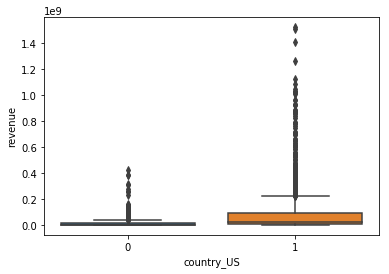

In [160]:
sns.boxplot(x='country_US',y='revenue',data=train)

In [161]:
columns = ['popularity','budget',
           'l_rev',
           'coll_rev_logav',
           'genre_ave',
          'prod_top','prod_ave',
           'year','country_US']

X = train[columns]

X_test = test[columns]

boost.fit(X,y)
pred = boost.predict(X_test)
pred = np.exp(pred)
submit['revenue'] = pred
submit.to_csv('0103-prod_c_US.csv')